In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import time
from math import exp
from tqdm import tqdm

from rbm.lieb_lattices import Fine_Lieb_RBM, A1_Lieb_RBM
from rbm.hex_lattices import Fine_Hex_RBM, A1_Hex_RBM
from rg.monotone import MLP, Gaussian
from utils.losses import free_energy_contrast
from utils.newton import find_root
from utils.hmc import HMC
from utils.grad import batch_grad, grad

In [2]:
device = torch.device('cuda')

In [3]:
def plot(*functions, xlim=(0, 2)):
    
    x_range = torch.linspace(*xlim, 100, device=device).unsqueeze(1)

    fig, axs = plt.subplots(len(functions), 1, sharex=True, figsize=(8, 2 * len(functions)))

    if len(functions) == 1:
        f_range = functions[0](x_range).cpu().detach()
        axs.plot(x_range.cpu().detach(), f_range)
        axs.axhline(0, color='black', linewidth=0.5)
        axs.axvline(0, color='black', linewidth=0.5)
        
        return fig, axs

    for i, f in enumerate(functions):
        
        f_range = f(x_range).cpu().detach()
        
        axs[i].plot(x_range.cpu().detach(), f_range)
        axs[i].axhline(0, color='black', linewidth=0.5)
        axs[i].axvline(0, color='black', linewidth=0.5)

    return fig, axs

# Models

In [4]:
flow = MLP(
    in_dims=1, 
    out_dims=1, 
    device=device
)
flow.eval();

In [5]:
lattice = 'lieb'
if lattice == 'lieb':
    fine = Fine_Lieb_RBM(device=device)
    coarse = A1_Lieb_RBM(device=device)
elif lattice == 'hex':
    fine = Fine_Hex_RBM(device=device)
    coarse = A1_Hex_RBM(device=device)

In [6]:
sampler = HMC(device=device)

Text(0.5, 1.0, 'Untrained RG Flow (gradient of C-function)')

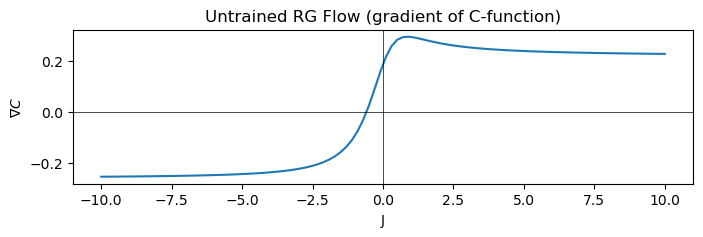

In [7]:
fig, ax = plot(flow, xlim=(-10, 10))
ax.set_ylabel(r'$\nabla C$')
ax.set_xlabel('J')
ax.set_title('Untrained RG Flow (gradient of C-function)')

# Training

In [8]:
epoch = 0
epochs = 1024
sample_batch_size = 32
cd_batch_size = 1024
k_fine = 64
k_coarse = 1

beta = lambda epoch : 64/(1 + exp( -16 * (epoch - (epochs / 2)) / epochs ))

In [9]:
optimizer = torch.optim.Adam(flow.parameters())

Js = []
losses = []
J = torch.randn(sample_batch_size, 1, device=device)

In [10]:
flow.train()
for epoch in tqdm(range(epoch, epoch + epochs)):
    optimizer.zero_grad()

    sampler.potential = lambda J : beta(epoch) * (flow(J) ** 2)

    # RG Flow
    J = sampler.step(J).detach()

    loss = 0
    for i in range(sample_batch_size):
        
        fine.J = J[i]
        coarse.J = J[i] + flow(J[i])
    
        # Loss
        loss += free_energy_contrast(
            fine, coarse, 
            batch_size=cd_batch_size, 
            k_fine=k_fine, 
            k_coarse=k_coarse
        )
    
    loss.backward()
    optimizer.step()

    Js.append(J.clone().detach())
    losses.append(float(loss))

100%|████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [02:18<00:00,  7.38it/s]


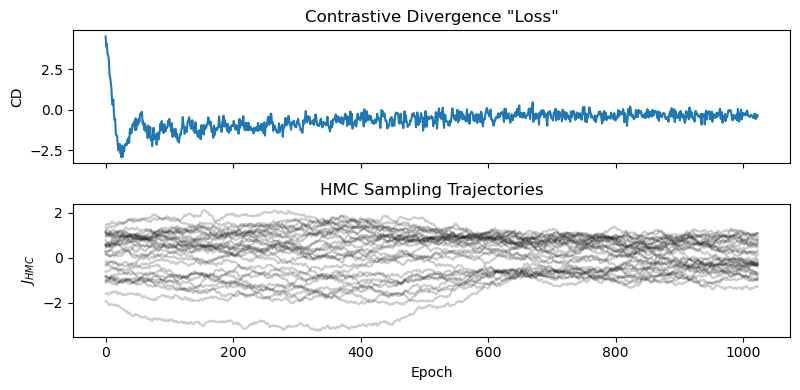

In [11]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax0.plot(losses)
ax0.set_ylabel('CD')
ax0.set_title('Contrastive Divergence "Loss"')

for traj in torch.cat(Js, dim=1):
    ax1.plot(traj.cpu().detach(), alpha=0.2, c='black')
ax1.set_ylabel(r'$J_{HMC}$')
ax1.set_xlabel('Epoch')
ax1.set_title('HMC Sampling Trajectories')
plt.tight_layout()

0.7592477202415466

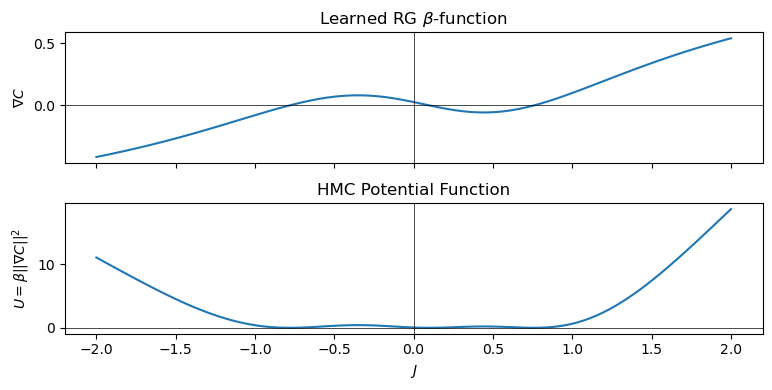

In [12]:
flow.eval()
fig, axs = plot(
    flow, 
    sampler.potential, 
    xlim=(-2, 2)
)
axs[0].set_ylabel(r'$\nabla C$')
axs[0].set_title(r'Learned RG $\beta$-function')
axs[1].set_xlabel(r'$J$')
axs[1].set_ylabel(r'$U = \beta || \nabla C ||^2$')
axs[1].set_title('HMC Potential Function')
plt.tight_layout()

find_root(torch.tensor([1.], device=device), flow)